In [2]:
library(dplyr)
library(stringr)
library(readr)
library(tidyr)
library(lfe)
library(ggplot2)
library(doMC)
library(lfe)
### Loading Data
fp <- '/nfs/sloanlab004/projects/covid_mobility_proj/data/'
safegraph <- read_csv(str_c(fp, 'safegraph_social_distancing_aggregate_county.csv'))
counties_long <- read_csv(str_c(fp, 'county_policy_long.csv'))
countyInfo <- read_csv(str_c(fp, 'countyInfo.csv'))
weather <- read_csv(str_c(fp, 'county_weather.csv'))
voteShare <- read_csv(str_c(fp, 'county_vote_shares_2016.csv'))
sci <- read_delim(str_c(fp, 'county_county_data.tsv'), delim ='\t', col_types = 'ddd')


weather %>%
  mutate(county_fips = as.numeric(county_fips)) %>%
  rename(ds = dt) -> weather

weather %>%
  inner_join(weather %>%
               group_by(county_fips) %>%
               tally() %>%
               filter(n == max(n)) %>%
               select(-n)) -> weather

Parsed with column specification:
cols(
  county_fips = col_double(),
  device_count = col_double(),
  completely_home_device_count = col_double(),
  part_time_work_behavior_devices = col_double(),
  full_time_work_behavior_devices = col_double(),
  ds = col_date(format = "")
)

Parsed with column specification:
cols(
  fips = col_double(),
  name = col_character(),
  state_abbv = col_character(),
  type = col_character(),
  dt = col_date(format = "")
)

Parsed with column specification:
cols(
  county_fips = col_double(),
  county_name = col_character(),
  state_abbv = col_character(),
  long = col_double(),
  lat = col_double()
)

Parsed with column specification:
cols(
  county_fips = col_character(),
  dt = col_date(format = ""),
  PRCP = col_double(),
  TMAX = col_double()
)

Parsed with column specification:
cols(
  county_fips = col_double(),
  djt_vs = col_double(),
  hrc_vs = col_double(),
  djt_margin = col_double()
)

Joining, by = "county_fips"



In [3]:
### Data Preprocessing
counties_long %>% 
  mutate(value = 1) %>%
  spread(key = type, value = value) -> countyPolicy

safegraph %>%
  group_by(county_fips) %>%
  summarize(n = n()) %>%
  filter(n == max(n)) %>%
  select(county_fips) %>%
  inner_join(sci %>% ungroup() %>% select(county_fips = user_county) %>% distinct()) %>%
  inner_join(countyPolicy %>% select(county_fips = fips) %>% distinct()) %>%
  semi_join(weather %>% select(county_fips) %>% distinct()) -> fips

safegraph %>%
  ungroup() %>%
  select(ds) %>%
  distinct() %>%
  arrange(ds) -> dates

safegraph %>%
  inner_join(fips) %>%
  arrange(county_fips, ds) %>%
  mutate(home_device_frac = completely_home_device_count/device_count,
         work_device_frac = (completely_home_device_count + part_time_work_behavior_devices)/device_count) %>%
  inner_join(countyInfo %>% select(-county_name)) %>%
  select(ds, county_fips, home_device_frac, work_device_frac, state_abbv) %>%
  left_join(countyPolicy, by = c('ds' = 'dt', 'county_fips' = 'fips', 'state_abbv')) %>%
  group_by(county_fips) %>%
  arrange(county_fips, ds) %>%
  fill(gatherings50, gatherings500, gyms_movies, restaurants, schools, stay_home) %>%
  replace_na(list(gatherings50 = 0, gatherings500 = 0, 
                  gyms_movies = 0, restaurants = 0, 
                  schools = 0, stay_home = 0)) %>%
  select(-name) %>%
  left_join(weather) -> df

df %>% 
  filter(ds >= as.Date('2020-03-01')) -> df

head(df)

Joining, by = "county_fips"

Joining, by = "county_fips"

Joining, by = "county_fips"

Joining, by = "county_fips"

Joining, by = "county_fips"

Joining, by = c("ds", "county_fips")



ds         county_fips home_device_frac work_device_frac state_abbv
1 2020-03-01 1001        0.2362245        0.3314626        AL        
2 2020-03-02 1001        0.1754155        0.3324009        AL        
3 2020-03-03 1001        0.1662855        0.3502123        AL        
4 2020-03-04 1001        0.1840174        0.3708709        AL        
5 2020-03-05 1001        0.1558463        0.3332229        AL        
6 2020-03-06 1001        0.1412305        0.3336166        AL        
  gatherings50 gatherings500 gyms_movies restaurants schools stay_home PRCP 
1 0            0             0           0           0       0          0.00
2 0            0             0           0           0       0          7.85
3 0            0             0           0           0       0         35.05
4 0            0             0           0           0       0         57.30
5 0            0             0           0           0       0         45.45
6 0            0             0           0           0       0          1.90
  TMAX    
1 20.26667
2 20.40000
3 22.40000
4 19.16667
5 15.53333
6 16.33333

In [10]:
library(usmap)
ds_county <- countypop %>% as.data.frame() 
ds_county$fips <- as.numeric(ds_county$fips)

Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”


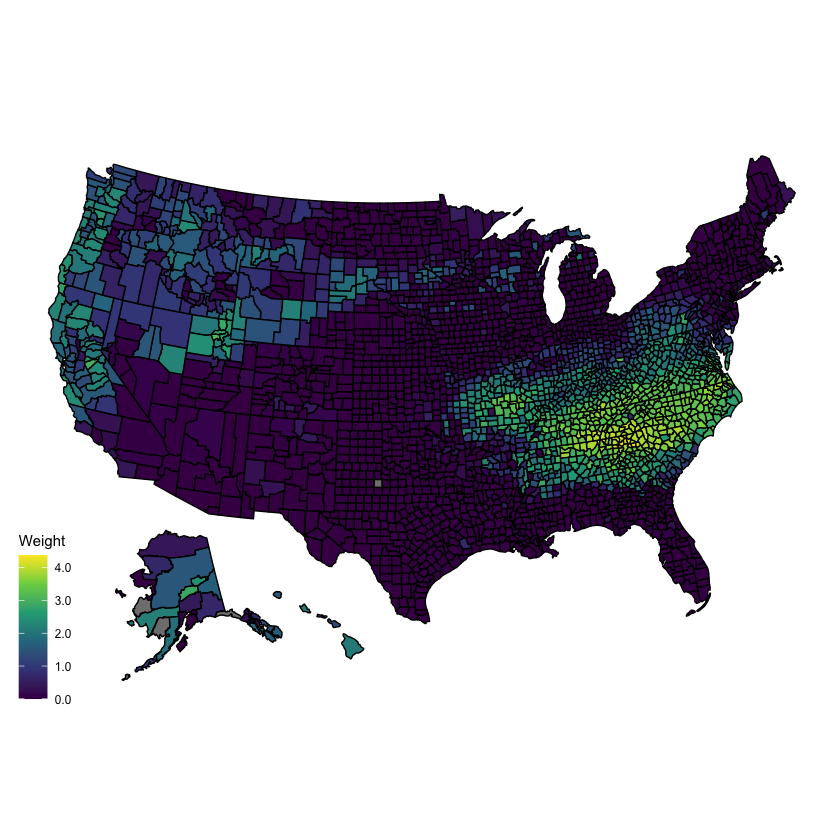

In [14]:
###########Weather patterns##########

###########PRECIPITATION#############
ds_weather_help <- df %>% select(ds,county_fips,PRCP,TMAX) %>% as.data.frame()
colnames(ds_weather_help)[2] <- "fips"
#ds_county
#
ds_county_1 <-  ds_county %>% left_join((ds_weather_help %>% filter(ds=="2020-03-25")), by = "fips")
ds_county_1$AAA <- log(1+ds_county_1$PRCP)
plot_usmap(data = ds_county_1, values = "AAA") + 
  scale_fill_continuous( type = "viridis",name = "Weight", label = scales::comma) 


Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”


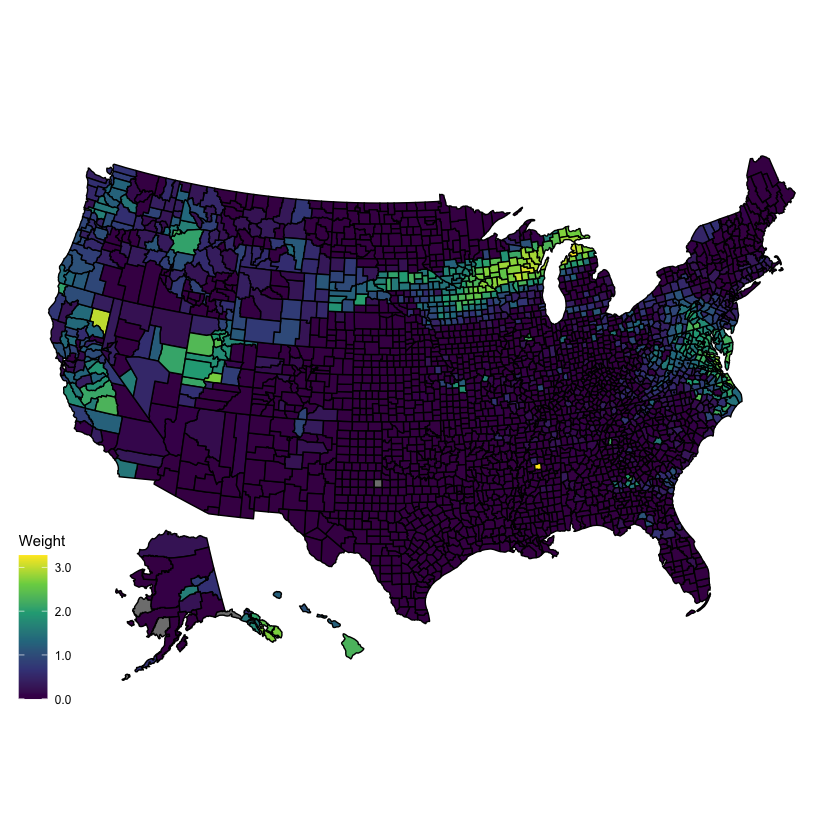

In [15]:
ds_weather_help <- df %>% select(ds,county_fips,PRCP,TMAX) %>% as.data.frame()
colnames(ds_weather_help)[2] <- "fips"
#ds_county
#
ds_county_1 <-  ds_county %>% left_join((ds_weather_help %>% filter(ds=="2020-03-26")), by = "fips")
ds_county_1$AAA <- log(1+ds_county_1$PRCP)
plot_usmap(data = ds_county_1, values = "AAA") + 
  scale_fill_continuous( type = "viridis",name = "Weight", label = scales::comma) 


Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”


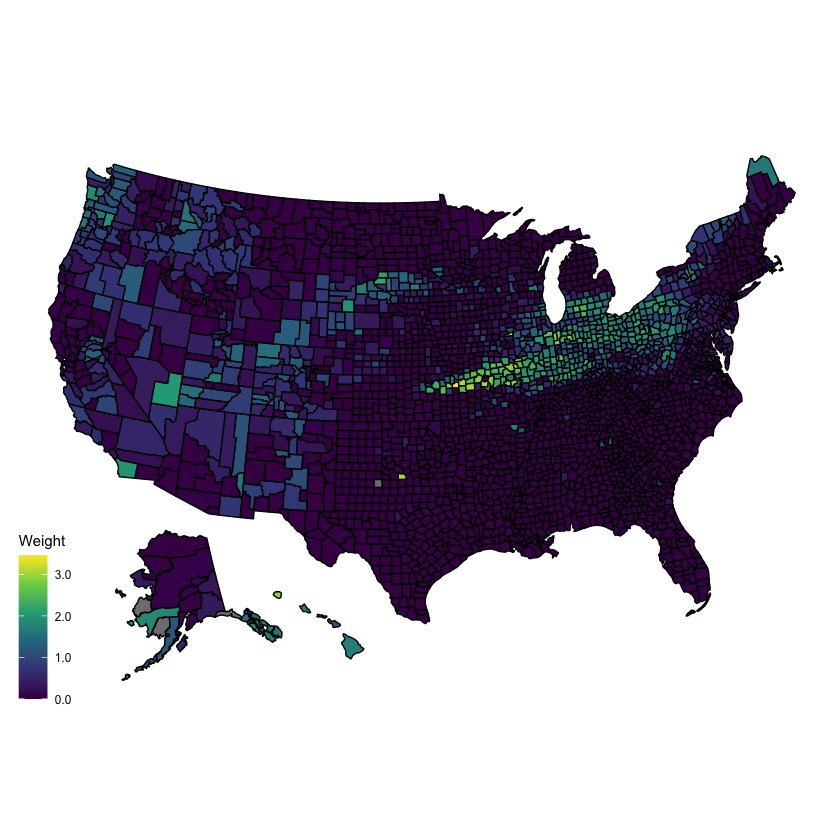

In [16]:
ds_weather_help <- df %>% select(ds,county_fips,PRCP,TMAX) %>% as.data.frame()
colnames(ds_weather_help)[2] <- "fips"
#ds_county
#
ds_county_1 <-  ds_county %>% left_join((ds_weather_help %>% filter(ds=="2020-03-27")), by = "fips")
ds_county_1$AAA <- log(1+ds_county_1$PRCP)
plot_usmap(data = ds_county_1, values = "AAA") + 
  scale_fill_continuous( type = "viridis",name = "Weight", label = scales::comma) 


Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”


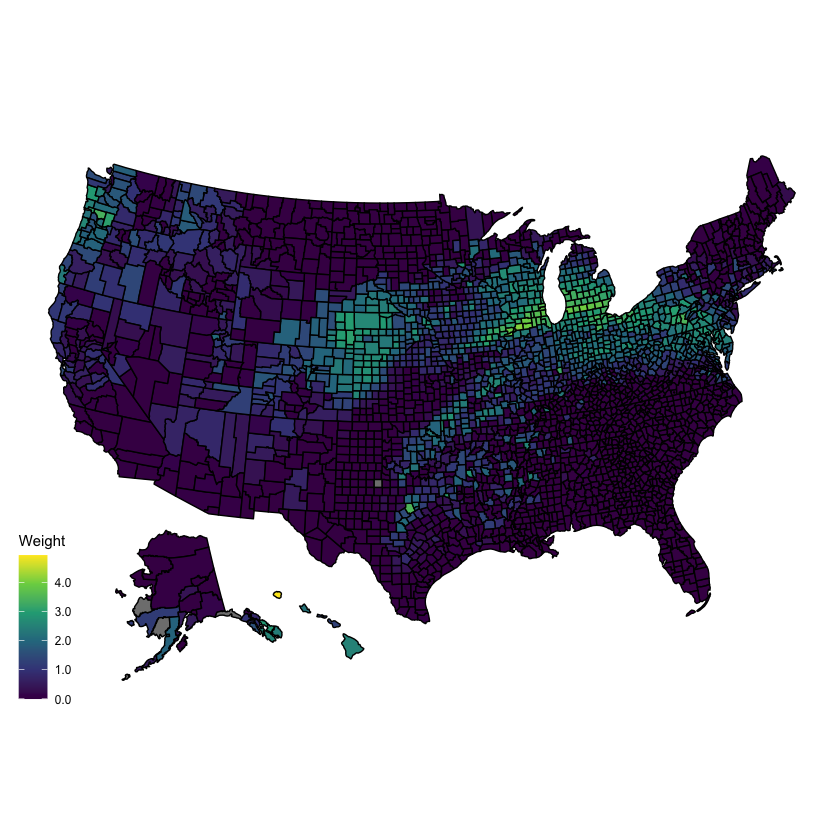

In [17]:
ds_weather_help <- df %>% select(ds,county_fips,PRCP,TMAX) %>% as.data.frame()
colnames(ds_weather_help)[2] <- "fips"
#ds_county
#
ds_county_1 <-  ds_county %>% left_join((ds_weather_help %>% filter(ds=="2020-03-28")), by = "fips")
ds_county_1$AAA <- log(1+ds_county_1$PRCP)
plot_usmap(data = ds_county_1, values = "AAA") + 
  scale_fill_continuous( type = "viridis",name = "Weight", label = scales::comma) 



Warning message in log(1 + ds_county_1$TMAX):
“NaNs produced”
Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”


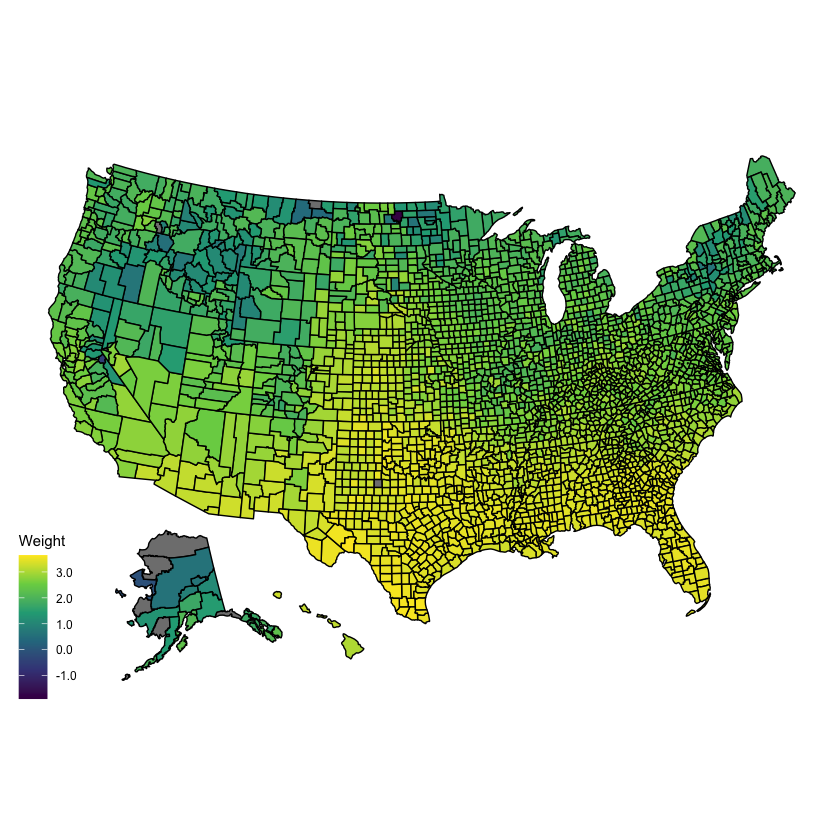

In [18]:
#############TEMPERATURE#############
ds_weather_help <- df %>% select(ds,county_fips,PRCP,TMAX) %>% as.data.frame()
colnames(ds_weather_help)[2] <- "fips"
#ds_county
#
ds_county_1 <-  ds_county %>% left_join((ds_weather_help %>% filter(ds=="2020-03-25")), by = "fips")
ds_county_1$AAA <- log(1+ds_county_1$TMAX)
plot_usmap(data = ds_county_1, values = "AAA") + 
  scale_fill_continuous( type = "viridis",name = "Weight", label = scales::comma) 

Warning message in log(1 + ds_county_1$TMAX):
“NaNs produced”
Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”


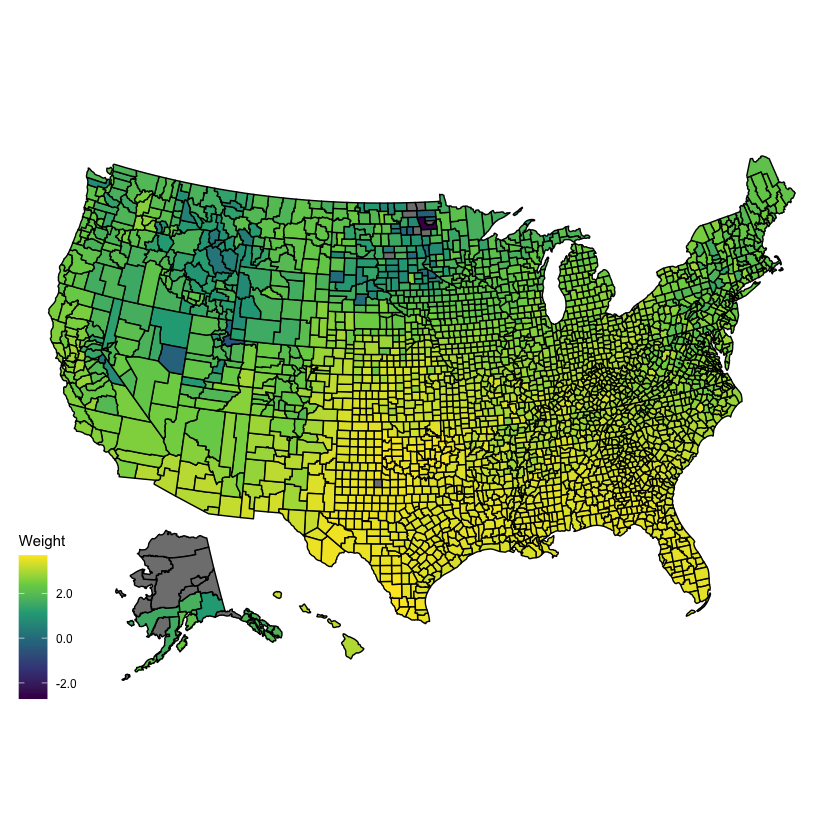

In [19]:
ds_weather_help <- df %>% select(ds,county_fips,PRCP,TMAX) %>% as.data.frame()
colnames(ds_weather_help)[2] <- "fips"
#ds_county
#
ds_county_1 <-  ds_county %>% left_join((ds_weather_help %>% filter(ds=="2020-03-26")), by = "fips")
ds_county_1$AAA <- log(1+ds_county_1$TMAX)
plot_usmap(data = ds_county_1, values = "AAA") + 
  scale_fill_continuous( type = "viridis",name = "Weight", label = scales::comma) 

Warning message in log(1 + ds_county_1$TMAX):
“NaNs produced”
Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”


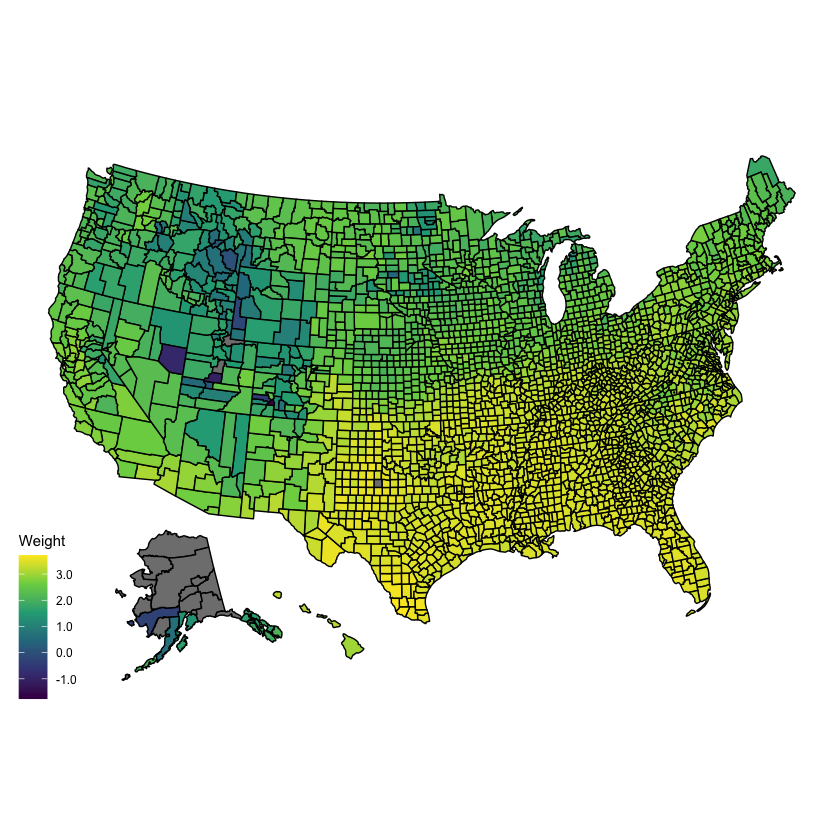

In [20]:
ds_weather_help <- df %>% select(ds,county_fips,PRCP,TMAX) %>% as.data.frame()
colnames(ds_weather_help)[2] <- "fips"
#ds_county
#
ds_county_1 <-  ds_county %>% left_join((ds_weather_help %>% filter(ds=="2020-03-27")), by = "fips")
ds_county_1$AAA <- log(1+ds_county_1$TMAX)
plot_usmap(data = ds_county_1, values = "AAA") + 
  scale_fill_continuous( type = "viridis",name = "Weight", label = scales::comma) 

Warning message in log(1 + ds_county_1$TMAX):
“NaNs produced”
Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”


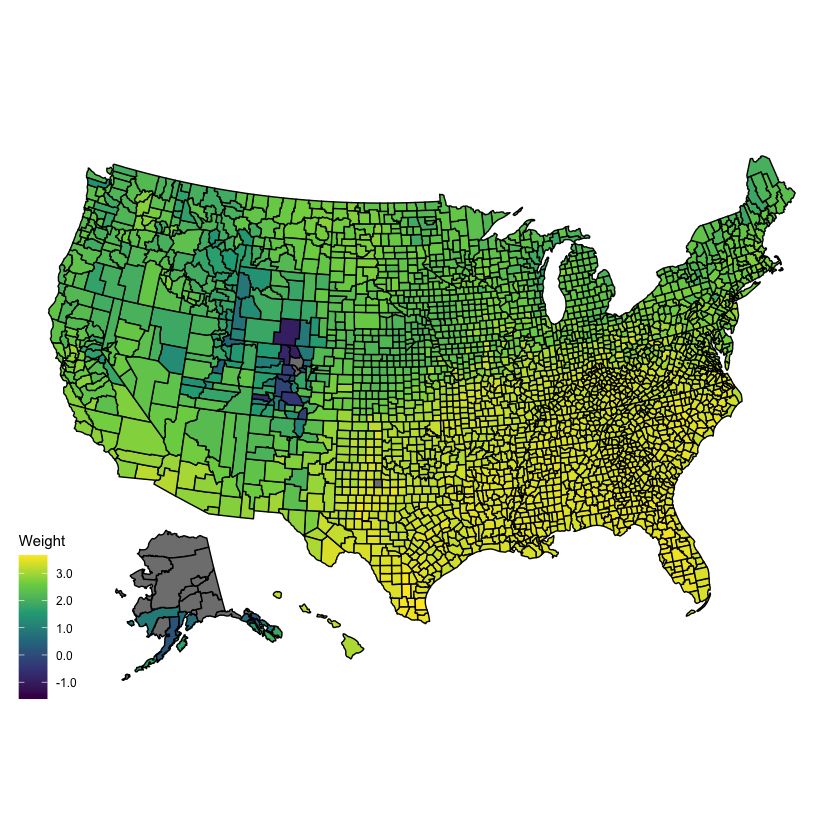

In [21]:
ds_weather_help <- df %>% select(ds,county_fips,PRCP,TMAX) %>% as.data.frame()
colnames(ds_weather_help)[2] <- "fips"
#ds_county
#
ds_county_1 <-  ds_county %>% left_join((ds_weather_help %>% filter(ds=="2020-03-28")), by = "fips")
ds_county_1$AAA <- log(1+ds_county_1$TMAX)
plot_usmap(data = ds_county_1, values = "AAA") + 
  scale_fill_continuous( type = "viridis",name = "Weight", label = scales::comma) 

user_county fr_county scaled_sci n     user_state_fips fr_state_fips
1 1001        1001      10197733    6122 1               1            
2 1001        1003         80006   26507 1               1            
3 1001        1005         93083    2001 1               1            
4 1001        1007        167754    2327 1               1            
5 1001        1009         48899    6987 1               1            
6 1001        1011        200281     666 1               1            
  w          
1 0.000000000
2 0.015222013
3 0.001336923
4 0.002801936
5 0.002452334
6 0.000957421

Adding missing grouping variables: `user_county`

Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”
Adding missing grouping variables: `user_county`

Warning message:
“Use of `map_df$x` is discouraged. Use `x` instead.”
Warning message:
“Use of `map_df$y` is discouraged. Use `y` instead.”
Warning message:
“Use of `map_df$group` is discouraged. Use `group` instead.”


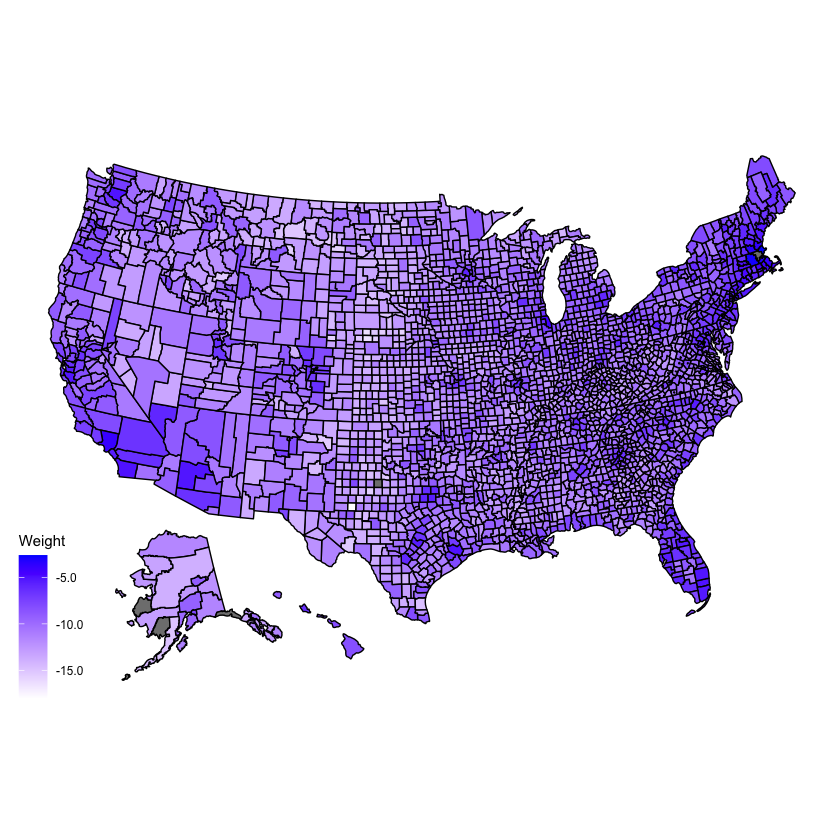

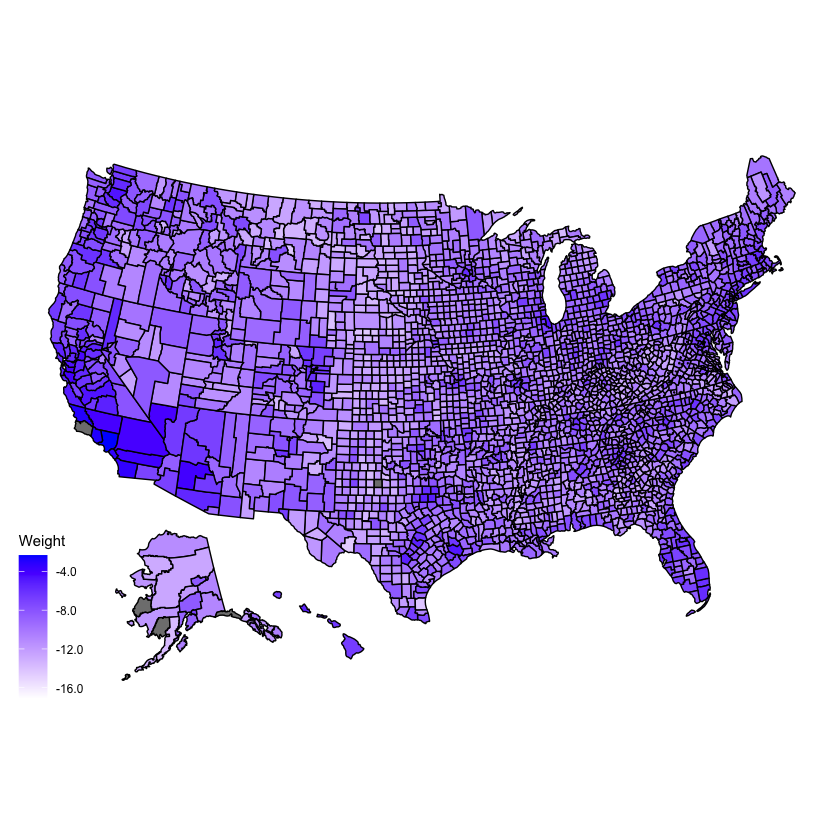

In [23]:
######The social graph between counties through the SCI

sci %>%
  inner_join(fips, by = c('user_county' = 'county_fips')) %>%
  inner_join(fips, by = c('fr_county' = 'county_fips')) %>%
  left_join(safegraph %>% 
              group_by(county_fips) %>% 
              summarize(n = max(device_count)), by = c('fr_county' = 'county_fips')) %>%
  mutate(user_state_fips = floor(user_county/1000), 
         fr_state_fips = floor(fr_county/1000), 
         w = ifelse(user_county == fr_county, 0 , scaled_sci * n)) %>%
  group_by(user_county) %>%
  mutate(w = w/sum(w)) %>% 
  arrange(user_county, fr_county) -> sci

head(sci)

########################################SCI Visualizations
#####For Middlesex county 25017
library(usmap)
sci_midd <- sci %>% filter(user_county==25017) 
sci_midd <- sci_midd %>% select(fr_county,w) %>% as.data.frame()
colnames(sci_midd)[2] <- "fips"

ds_county <- countypop %>% as.data.frame() 
ds_county$fips <- as.numeric(ds_county$fips)
ds_county <- ds_county %>% left_join(sci_midd, by="fips")
ds_county$w <- log(ds_county$w )

plot_usmap(data = ds_county, values = "w") + 
  scale_fill_continuous( low = "white", high = "blue",name = "Weight", label = scales::comma) 



####Santa Barbara 06083
sci_sb <- sci %>% filter(user_county==06083) 
sci_sb <- sci_sb %>% select(fr_county,w) %>% as.data.frame()
colnames(sci_sb)[2] <- "fips"

ds_county <- countypop %>% as.data.frame() 
ds_county$fips <- as.numeric(ds_county$fips)
ds_county <- ds_county %>% left_join(sci_sb, by="fips")
ds_county$w <- log(ds_county$w )

plot_usmap(data = ds_county, values = "w") + 
  scale_fill_continuous( low = "white", high = "blue",name = "Weight", label = scales::comma) 

########################################